In [21]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import ast
from typing import List, Tuple

from collections import defaultdict
from typing import List                                                                                                         
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

# 30 sec

In [2]:
from Enum.EnergyRange import EnergyRange
from Enum.Flavour import Flavour

In [3]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [4]:
csvs_medium_signal_to_noise = {
    r"Neutrino vs. Noise, E$\in$(10TeV,1PeV), train(250m), val(250m)": "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250410/model_20250330_203043/112744/predictions_epoch_083_val_loss_0.0046.csv"
}

In [11]:
def get_neutrino_signal_logits(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["logits"] = df["logits"].apply(safe_parse)

    neutrino_signal = df[df["target_class"] == 0]["logits"]
    noise = df[df["target_class"] == 1]["logits"]

    logit_neutrino_signal = neutrino_signal.apply(lambda x: x[0]).to_numpy()
    logit_noise = noise.apply(lambda x: x[0]).to_numpy()

    return logit_neutrino_signal, logit_noise

In [44]:
def plot_logit_distribution(df: pd.DataFrame, 
                            id: str,
                            manifier: Tuple[float, float] = None) -> None:
    logit_neutrino_signal, logit_noise = get_neutrino_signal_logits(df)
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(logit_neutrino_signal, binwidth=0.01)
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(logit_neutrino_signal, bins=bins, label=r'$\nu_e$', color=getColour(0), histtype='step', linewidth=2)
    ax.hist(logit_noise, bins=bins, label=r'$\nu_\mu$', color=getColour(2), histtype='step', hatch='\\', linewidth=2)
    
    
    ax.set_title(f"logit distribution of {id}")

    ax.set_xlabel('Logit')
    ax.set_ylabel('Counts')
    if manifier:
        ax.set_xlim(manifier)
    else:
        ax.set_xlim(-0.1, 1.0)
    d_nu = {
        r'$\nu$': "",
        "N": len(logit_neutrino_signal),
        "max": np.max(logit_neutrino_signal),
        "min": np.min(logit_neutrino_signal),
        "mean": np.mean(logit_neutrino_signal),
        "median": np.median(logit_neutrino_signal),
        }
    d_noise = {
        "noise": "",
        "N": len(logit_noise),
        "max": np.max(logit_noise),
        "min": np.min(logit_noise),
        "mean": np.mean(logit_noise),
        "median": np.median(logit_noise),
        }
    add_text_to_ax(0.2, 0.95, nice_string_output(d_nu), ax, fontsize=12)
    add_text_to_ax(0.2, 0.75, nice_string_output(d_noise), ax, fontsize=12)

    ax.legend()

In [45]:
def plot_ROC(df: pd.DataFrame, id: str) -> None:
    # Parse logits
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x
    df["logits"] = df["logits"].apply(safe_parse)

    # Get true labels and scores
    y_true = df["target_class"].to_numpy()
    y_scores = df["logits"].apply(lambda x: x[0]).to_numpy()  # score for class 0

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=0)
    roc_auc = auc(fpr, tpr)

    # Plotting
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve: {id}")
    ax.legend()

In [46]:
def plot_csvs(csvs:dict, is_magnifier_on:bool):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        plot_logit_distribution(df, id)
        plot_ROC(df, id)
        # print(df[['target_class','pred_class','target_one_hot_pid','logits']].head())
        # print(get_neutrino_signal_logits(df)[0])

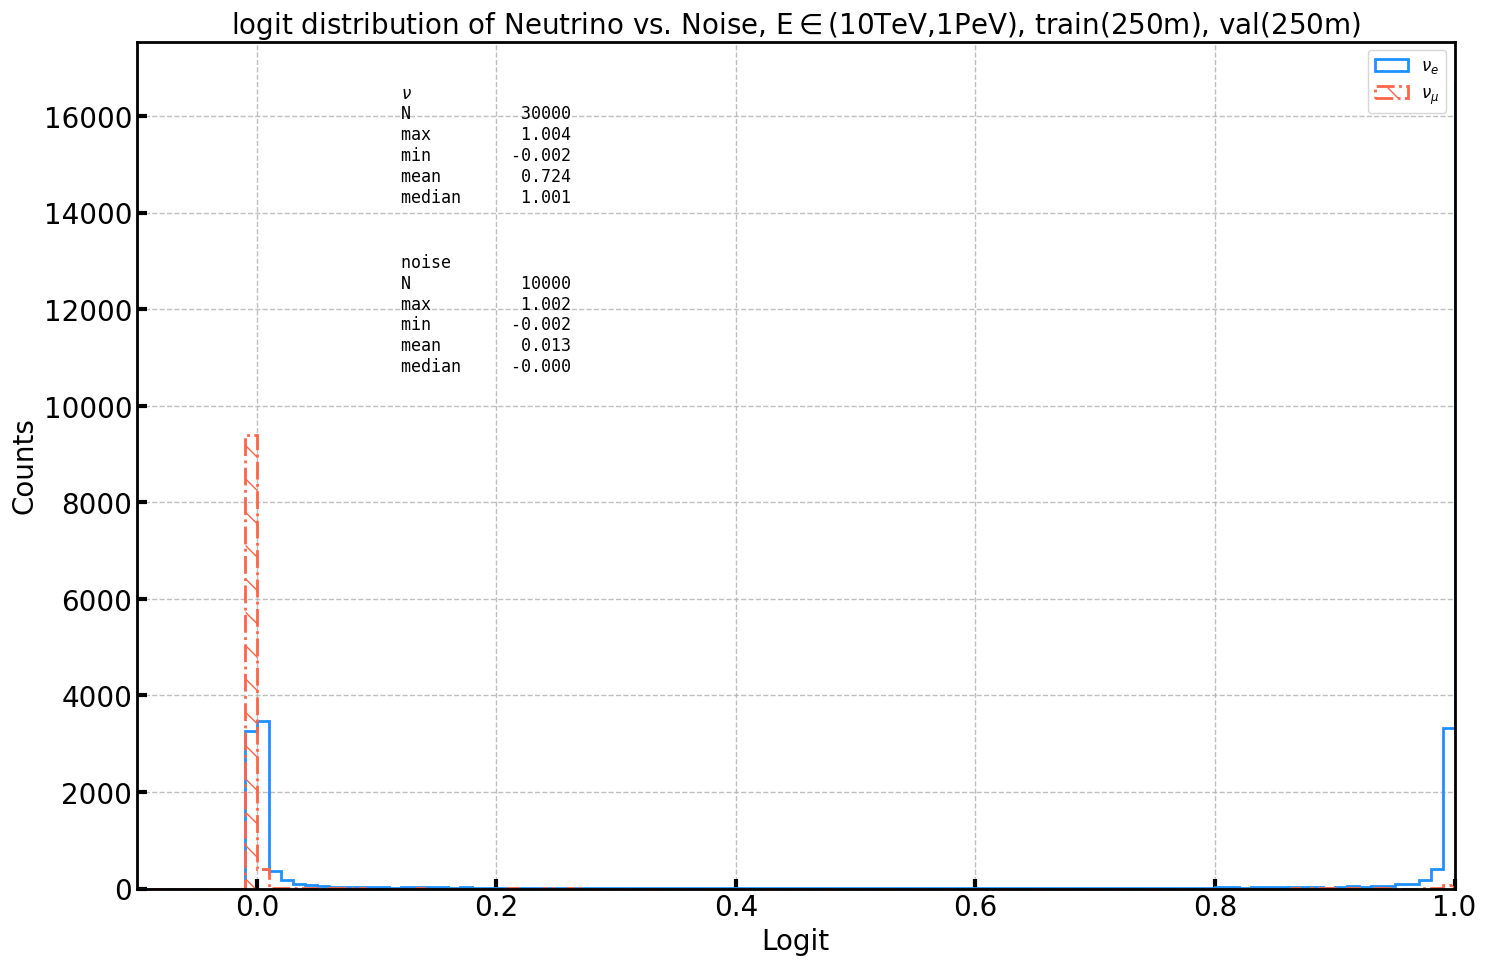

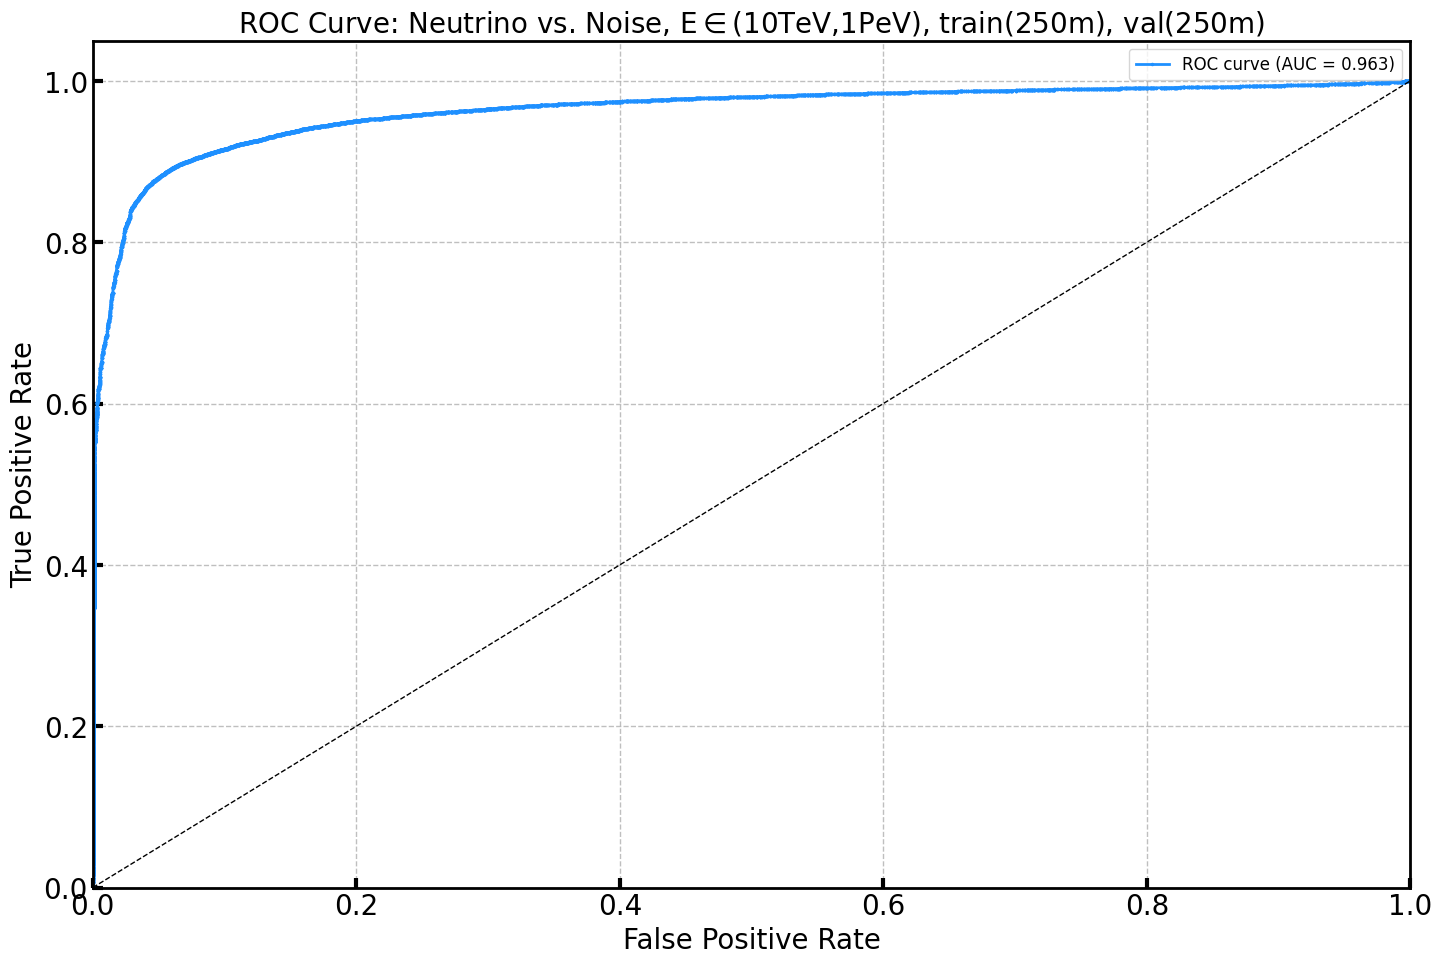

In [47]:
plot_csvs(csvs_medium_signal_to_noise, False)